In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF


In [2]:
df = pd.read_csv('./PARAFAC implementation/Testing data/combined_sensor_data_average_ok_values.csv',index_col = 0)

C:\Users\Sverrir\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.Name

3           K-RVK-001-RS113
6           K-RVK-001-RS113
9           K-RVK-001-RS113
12          K-RVK-001-RS113
15          K-RVK-001-RS113
                 ...       
27176471    K-RVK-116-RS111
27176474    K-RVK-116-RS111
27176477    K-RVK-116-RS111
27176480    K-RVK-116-RS111
27176482    K-RVK-116-RS111
Name: Name, Length: 9079253, dtype: object

In [4]:
df_test = df.loc[df.Name == 'K-RVK-036-RS211']
df_test.index = pd.DatetimeIndex(df_test.CTime)
# df_test = df_test.loc[df_test.OkPct >= 98]
# df_test = df_test.loc[df_test.Flag == 524480]
# x = df_test.loc[(df_test.CType == 4) & (df_test.Val > 0),:].Val

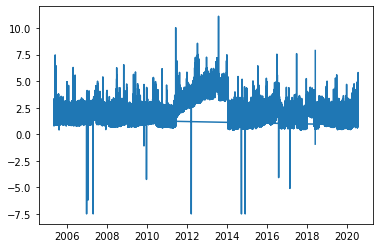

In [5]:
plt.plot(df_test.Val)

In [6]:
x = df_test.loc[(df_test.Val > 0),:].Val
x = x.resample('1h').mean()
x = x.fillna(method='ffill')
weekhour_index = x.index.weekday * 24 + x.index.hour
first_0 = np.argwhere(weekhour_index == 0)[0,0]
last_0 = np.argwhere(weekhour_index == 0)[-1,0]
x = x.iloc[first_0:last_0]
X = x.values.reshape((-1,7,24))

In [7]:
import datetime as dt

In [8]:
leak_dict = {
    dt.date(2019,8, 1):['Fáfnisnes 24','Meðal'],
    dt.date(2019,6, 4):['Bauganes 3','Lítill'],
    dt.date(2016,7,14):['Bauganes 19','Lítill'],              
    dt.date(2011,2,28):['Skildinganes 4','Meðal'],
    dt.date(2013,8,24):['Skildinganes 19','Meðal'],
    dt.date(2014,1,30):['Skildinganes 33','Meðal']
}

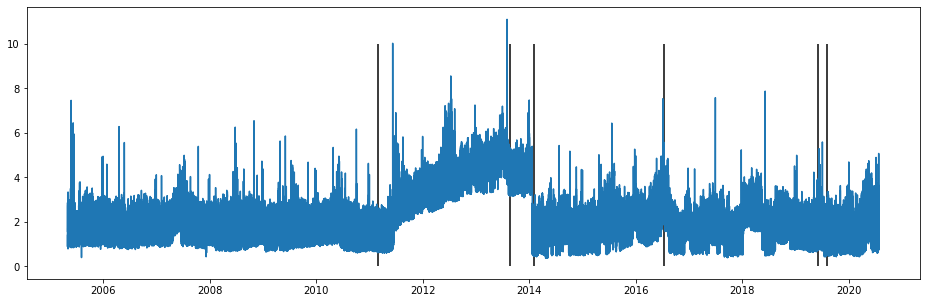

In [9]:
plt.figure(figsize=(16,5))
plt.plot(x)
plt.vlines(list(leak_dict.keys()),0,10)
plt.show()

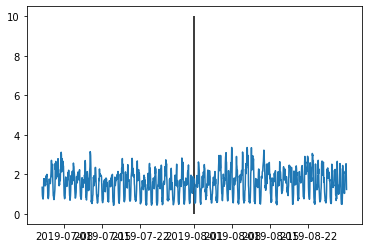

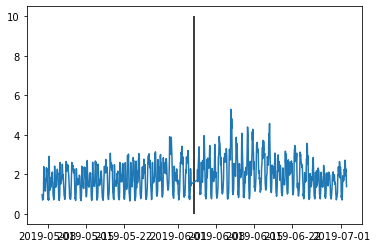

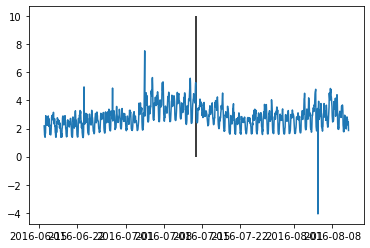

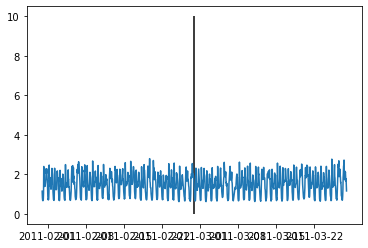

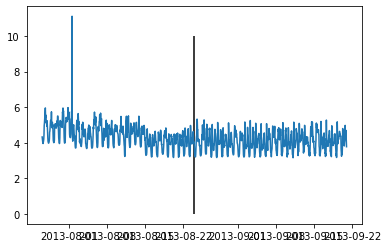

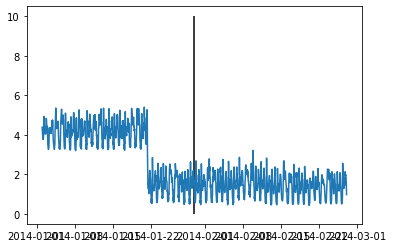

In [10]:
for key in leak_dict.keys():
    subset = df_test.loc[key-dt.timedelta(weeks=4):key+dt.timedelta(weeks=4)]
    plt.plot(subset.Val)
    plt.vlines(key,0,10)
    plt.show()

In [11]:
def NMF_with_flat_factor(X,n_components,max_iter=10000,tol = 1e-10):
    n,p = X.shape    
    flat_profile = np.ones((1,168))/(168**(1/2))
    nmf = NMF(n_components=n_components,init='custom',max_iter = 1,tol=1e-10,)
    
    H_init = np.abs(np.random.normal(0,1,(n_components,p)))
    H_init[0] = np.ones(p)/(p**(1/2))
    W_init = np.abs(np.random.normal(0,1,(n, n_components)))
    
    W = nmf.fit_transform(X,H=H_init,W=W_init)
    H = nmf.components_
    for i in range(max_iter-1):
        W = nmf.fit_transform(X,H=H,W=W)
        H = nmf.components_
        H[0] = flat_profile
    
    return nmf

In [12]:
rank = 3
nmf = NMF_with_flat_factor(X.reshape(-1,168),rank)

# Split the abundance estimate and reconstruct & compare with single overall estimate from abundances

In [13]:
# estimated_abundances = nmf.transform(X.reshape(-1,168))
# isolated_abundances = np.zeros([rank] + list(estimated_abundances.shape))
# for i in range(rank):
#     isolated_abundances[i,:,i] = estimated_abundances[:,i]
    
# split_predictictions = np.array([nmf.inverse_transform(x).ravel() for x in isolated_abundances])
# df_split_predictions = pd.DataFrame(original_predictictions.T,index=x.index)

# df_single_nmf_prediction = pd.DataFrame(nmf.inverse_transform(nmf.transform(X.reshape(-1,168))).ravel(),index=x.index)

In [14]:
from scipy.optimize import nnls
def predict_one_week(b,y):
    # Solve the problem of xb = y
    
    x = nnls(b,y,)
    return x[0]

In [15]:
def get_strides_and_shift(array,window = 168):   
    n = array.shape[0] - window + 1
    arr_strided = np.lib.stride_tricks.as_strided(array, shape=[n, window], strides=2*array.strides)
    shifts = np.arange(0,len(arr_strided))%168
    return arr_strided,shifts

In [16]:
x_flat = X.ravel()
profile_shift_dict = {i:np.roll(nmf.components_.T,-i,axis=0) for i in range(168)}
X_strided,shifts = get_strides_and_shift(x_flat)

pred_stack = np.array([predict_one_week(profile_shift_dict[shifts[i]],X_strided[i]) for i in range(len(X_strided))])

In [17]:
predictions = np.zeros((len(pred_stack),168))
separate_predictions = np.zeros((rank,len(pred_stack),168))

In [18]:
for i,abundance_estimates in enumerate(pred_stack):
#     print(profile_shift_dict[i%168].shape)
    predictions[i] = abundance_estimates.reshape(1,-1)@profile_shift_dict[i%168].T
    for p,(abundance,pattern) in enumerate(zip(abundance_estimates,profile_shift_dict[i%168].T)):
        separate_predictions[p,i] = abundance*pattern

In [19]:
predictions_fixed = np.zeros((len(x_flat),168))
seperate_predictions_fixed = np.zeros((rank,len(x_flat),168))
for i in range(168):
    start = i
    end = np.min([-167+i,-1])
#     print(start,end)
    if i == 167:
        predictions_fixed[start:,i] = predictions[:,i]
        for s in range(len(separate_predictions)):
            seperate_predictions_fixed[s,start:,i] = separate_predictions[s,:,i]
    else:
        for s in range(len(separate_predictions)):
            seperate_predictions_fixed[s,start:end,i] = separate_predictions[s,:,i]
        predictions_fixed[start:end,i] = predictions[:,i]
        
predictions_fixed[predictions_fixed == 0] = None
prediction_final = np.nanmean(predictions_fixed,axis=1)

separate_predictions_final = np.zeros([len(separate_predictions),len(prediction_final)])
for s in range(len(separate_predictions)):
    seperate_predictions_fixed[seperate_predictions_fixed == 0] = None
    separate_predictions_final[s] = np.nanmean(seperate_predictions_fixed[s],axis=1)

C:\Users\Sverrir\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


In [20]:
df_final_predictions = pd.DataFrame(separate_predictions_final.T,index=x.index)

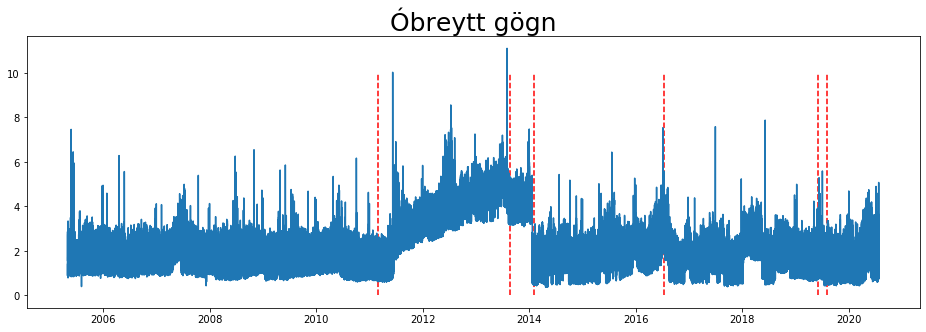

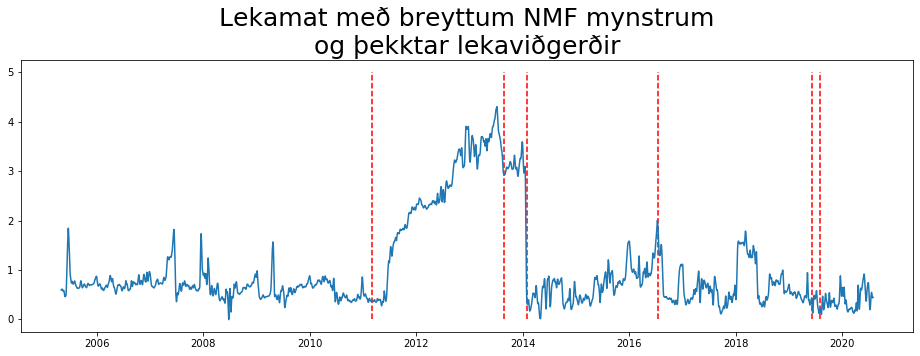

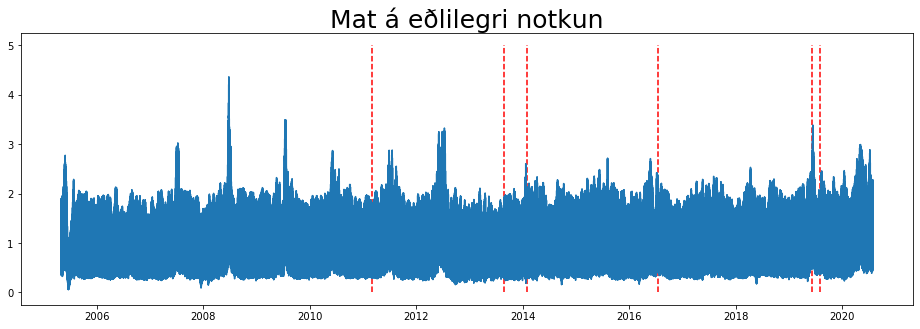

In [21]:
plt.figure(figsize=(16,5))
plt.title('Óbreytt gögn',fontsize=25)
plt.plot(x)
plt.vlines(list(leak_dict.keys()),0,10,linestyle='--',color='red')
plt.show()
############
plt.figure(figsize=(16,5))
plt.plot(df_final_predictions.loc[:,0])
plt.vlines(list(leak_dict.keys()),0,5,linestyle='--',color='red')
# for key in leak_dict.keys():
#     x_loc = key+dt.timedelta(weeks=2)
#     y_loc = df_final_predictions.loc[key-dt.timedelta(weeks=4):key,0].max()
#     text = '"' + leak_dict[key][1] + ' leki"'
#     plt.text(x_loc,
#              y_loc,
#              text,color='Black',fontsize=20)
plt.title('Lekamat með breyttum NMF mynstrum\nog þekktar lekaviðgerðir',fontsize=25)
plt.show()
#############
plt.figure(figsize=(16,5))
plt.plot(df_final_predictions.loc[:,1:].sum(axis=1))
plt.vlines(list(leak_dict.keys()),0,5,linestyle='--',color='red')
plt.title('Mat á eðlilegri notkun',fontsize=25)
plt.show()

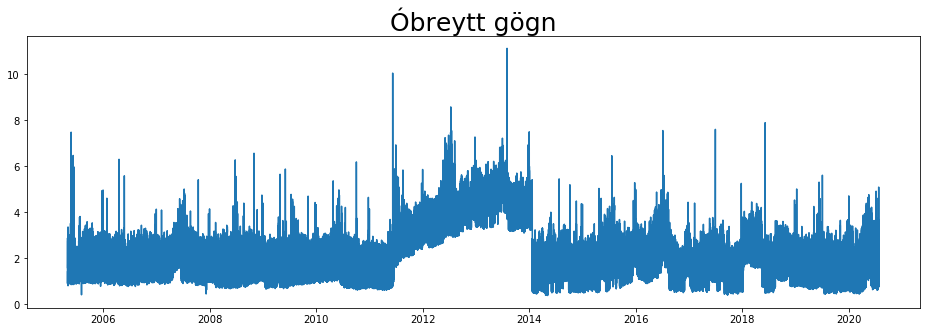

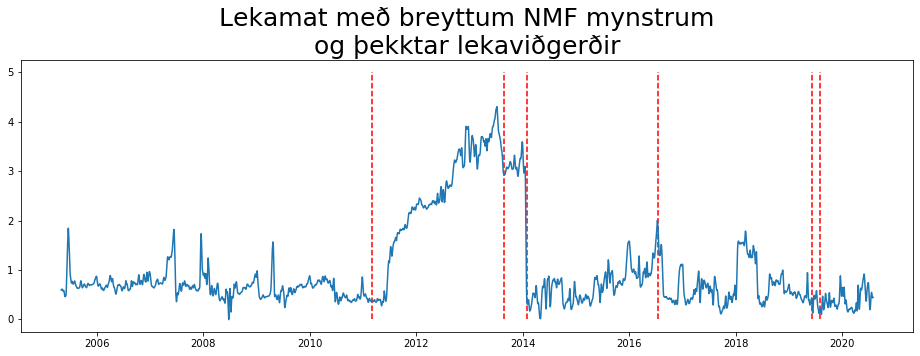

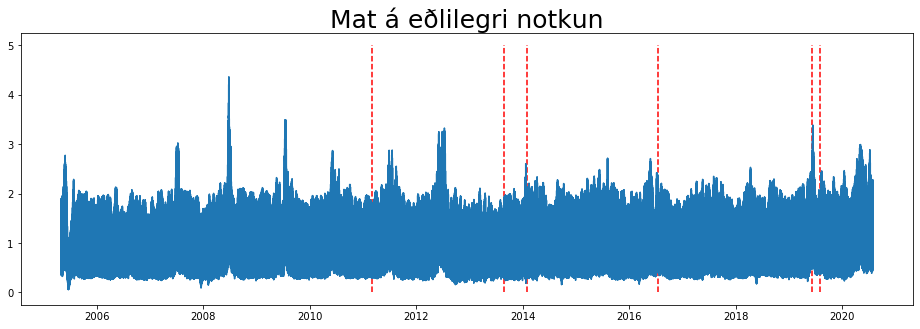

In [22]:
plt.figure(figsize=(16,5))
plt.title('Óbreytt gögn',fontsize=25)
plt.plot(x)
# plt.vlines(list(leak_dict.keys()),0,10,linestyle='--',color='red')
plt.show()
############
plt.figure(figsize=(16,5))
plt.plot(df_final_predictions.loc[:,0])
plt.vlines(list(leak_dict.keys()),0,5,linestyle='--',color='red')
plt.title('Lekamat með breyttum NMF mynstrum\nog þekktar lekaviðgerðir',fontsize=25)
plt.show()
#############
plt.figure(figsize=(16,5))
plt.plot(df_final_predictions.loc[:,1:].sum(axis=1))
plt.vlines(list(leak_dict.keys()),0,5,linestyle='--',color='red')
plt.title('Mat á eðlilegri notkun',fontsize=25)
plt.show()

In [23]:
from scipy.ndimage import gaussian_filter

In [24]:
# for sigma in np.logspace(0,4,10):
#     df_2nd_gaussian = pd.DataFrame(gaussian_filter(df_final_predictions.loc[:,0],sigma=sigma,order=1,),index=x.index)

#     plt.figure(figsize=(16,5))
#     plt.plot(df_2nd_gaussian.loc[:,0])
#     plt.vlines(list(leak_dict.keys()),min(df_2nd_gaussian.loc[:,0]),max(df_2nd_gaussian.loc[:,0]),linestyle='--',color='red')
#     plt.title('Gaussian derivative of \n estimated leakage with improved version of modified NMF\n and labels for a few know leakage repairs',fontsize=25)
#     plt.grid()
#     plt.show()

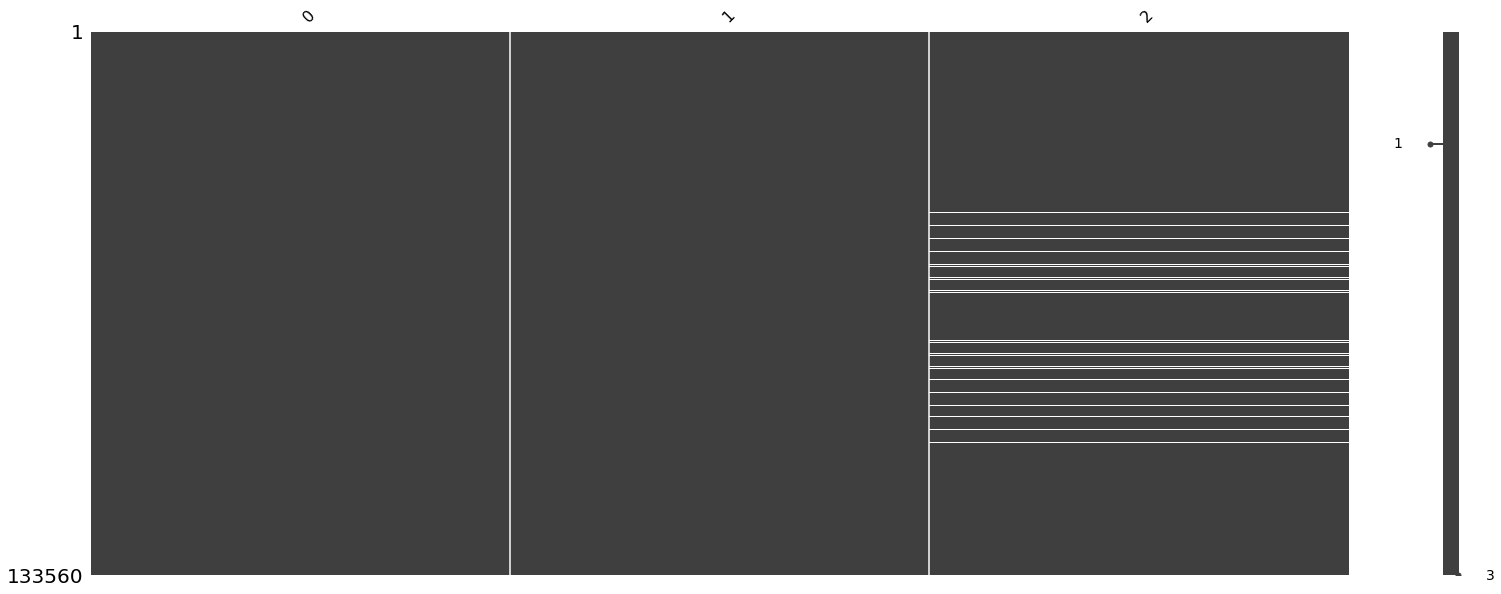

In [25]:
from missingno import matrix
matrix(df_final_predictions)

In [26]:
df_final_predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133560 entries, 2005-05-02 00:00:00 to 2020-07-26 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       133551 non-null  float64
 1   1       133560 non-null  float64
 2   2       127995 non-null  float64
dtypes: float64(3)
memory usage: 4.1 MB


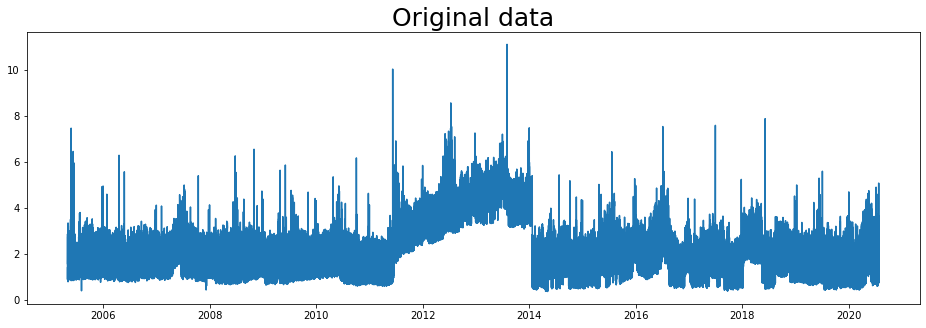

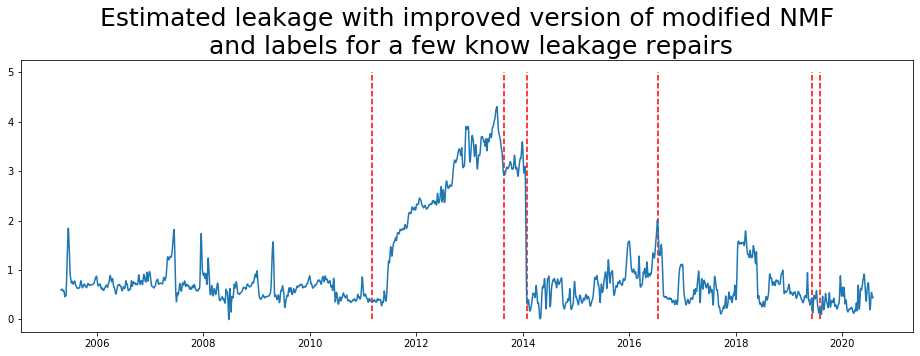

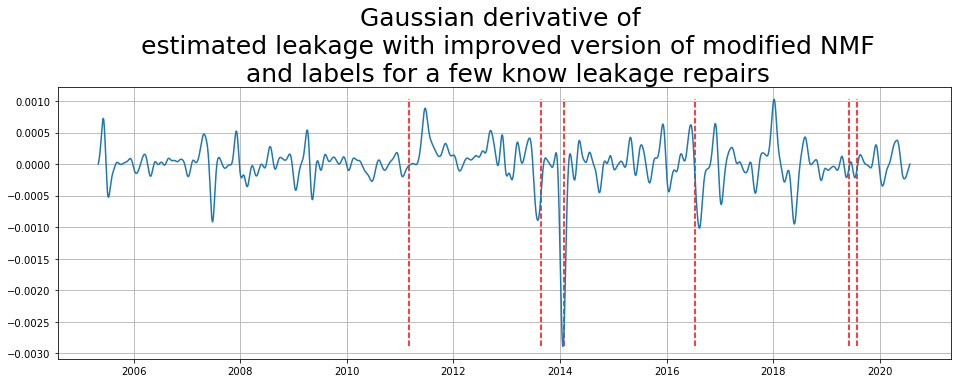

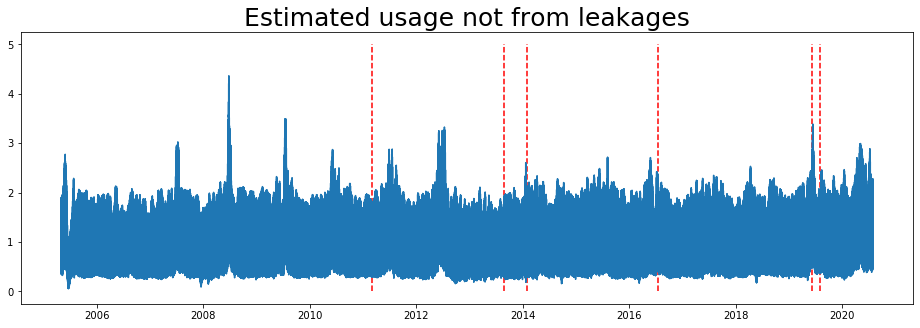

In [27]:
plt.figure(figsize=(16,5))
plt.title('Original data',fontsize=25)
plt.plot(x)
# plt.vlines(list(leak_dict.keys()),0,10,linestyle='--',color='red')
plt.show()

############
plt.figure(figsize=(16,5))
plt.plot(df_final_predictions.loc[:,0])
plt.vlines(list(leak_dict.keys()),0,5,linestyle='--',color='red')
plt.title('Estimated leakage with improved version of modified NMF\n and labels for a few know leakage repairs',fontsize=25)
plt.show()

#############
df_2nd_gaussian = pd.DataFrame(gaussian_filter(df_final_predictions.fillna(method='ffill').loc[:,0],400,order=1),index=x.index)

plt.figure(figsize=(16,5))
plt.plot(df_2nd_gaussian.loc[:,0])
plt.vlines(list(leak_dict.keys()),min(df_2nd_gaussian.loc[:,0]),max(df_2nd_gaussian.loc[:,0]),linestyle='--',color='red')
plt.title('Gaussian derivative of \n estimated leakage with improved version of modified NMF\n and labels for a few know leakage repairs',fontsize=25)
plt.grid()
plt.show()

#############
plt.figure(figsize=(16,5))
plt.plot(df_final_predictions.loc[:,[1,2]].sum(axis=1))
plt.vlines(list(leak_dict.keys()),0,5,linestyle='--',color='red')
plt.title('Estimated usage not from leakages',fontsize=25)
plt.show()

# Mean square errors

In [29]:
components = nmf.components_
df_raw_NMF = pd.DataFrame(nmf.inverse_transform(nmf.transform(X.reshape(-1,168),)).ravel(),index=x.index)
df_lsq_NMF = pd.DataFrame(np.array([predict_one_week(components.T,tmp_week)[[0]]*components[0] for tmp_week in X.reshape(-1,168)]).ravel(),index=x.index)
df_imp_NMF = df_final_predictions.copy()


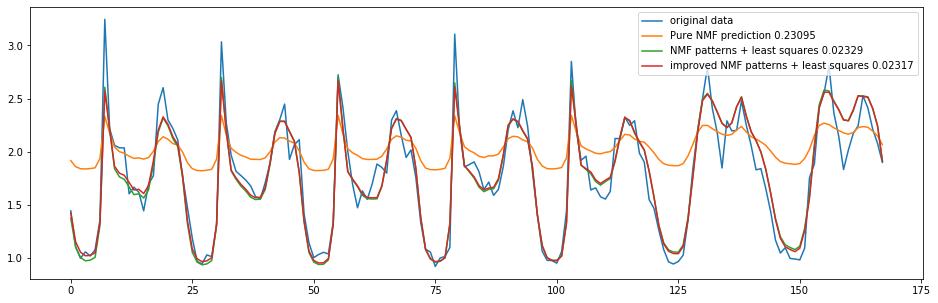

In [30]:
# Original
single_week = X.reshape(-1,168)[20:21]

# NMF preidction
reconstruct = nmf.inverse_transform(nmf.transform(single_week,)).T
reconstruct = (nmf.transform(single_week,)@nmf.components_)[0]

# NMF components + least squares
components = nmf.components_
abundances = predict_one_week(components.T,single_week.ravel())
reconstructed_least_squares = abundances@components

# Improved NMF + least squares
improved_prediction = df_final_predictions.iloc[20*168:21*168].sum(axis=1).values

#### MSE
MSE_func = (lambda x:np.power(x,2).mean())

NMF_MSE = MSE_func(single_week - reconstruct)
NMF_LST_MSE = MSE_func(single_week - reconstructed_least_squares)
NMF_LST_MSE_Improved = MSE_func(single_week - improved_prediction)


### PLOT
plt.figure(figsize=(16,5))
plt.plot(single_week.T)
plt.plot(reconstruct)
plt.plot(reconstructed_least_squares.T)
plt.plot(improved_prediction.T)
plt.plot()

## 

plt.legend([f'original data',
            f'Pure NMF prediction {np.round(NMF_MSE,5)}',
            f'NMF patterns + least squares {np.round(NMF_LST_MSE,5)}',
            f'improved NMF patterns + least squares {np.round(NMF_LST_MSE_Improved,5)}'])
plt.show()

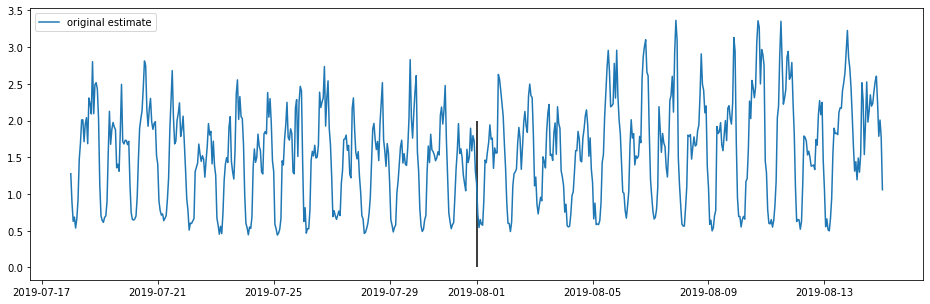

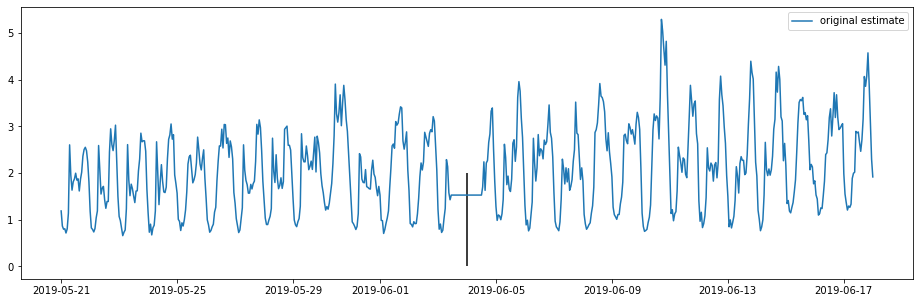

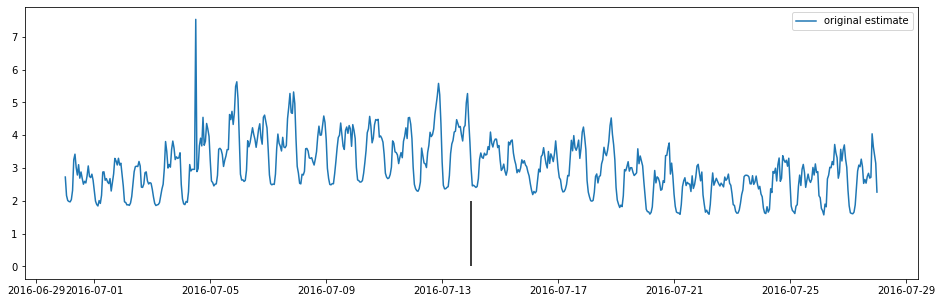

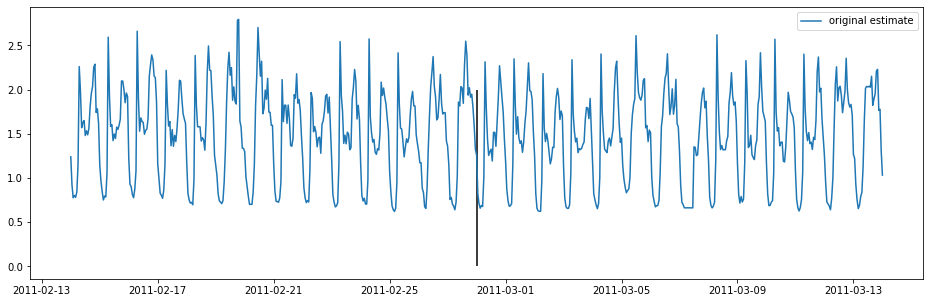

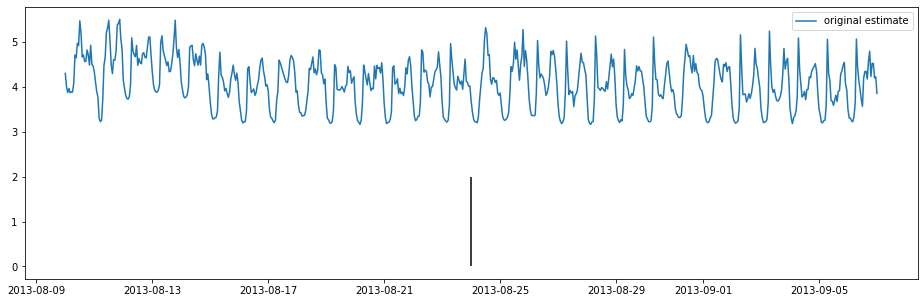

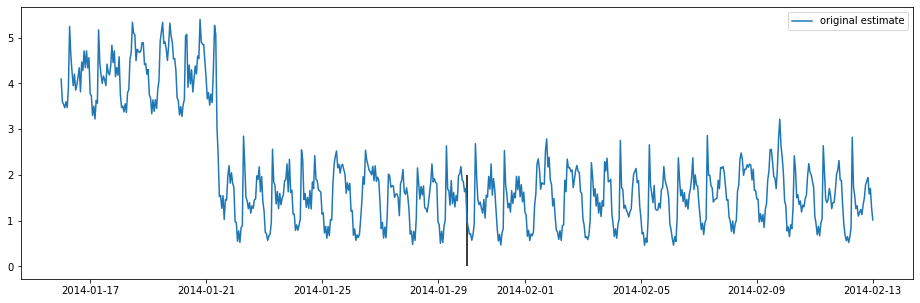

In [31]:
for key in leak_dict.keys():
    plt.figure(figsize=(16,5))
    start,end = key-dt.timedelta(weeks=2),key+dt.timedelta(weeks=2)
    ###
#     subset = df_single_nmf_prediction.loc[start:end]
#     plt.plot(subset.sum(axis=1))
    
#     subset = df_final_predictions.loc[start:end]
#     plt.plot(subset.sum(axis=1))
    
    subset = x.loc[start:end]
    plt.plot(subset)
    plt.legend(['original estimate','improved estimate','real data'])
    
    ### Estimate
    ### Real data
#     subset = df_test.loc[start:end]
#     plt.plot(subset.Val)
    ###
    
    plt.vlines(key,0,2)
    plt.show()

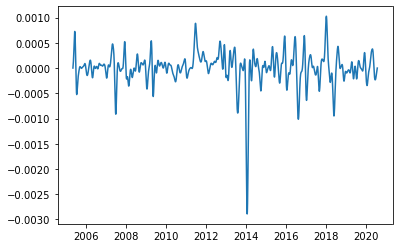

In [34]:
plt.plot(df_2nd_gaussian)

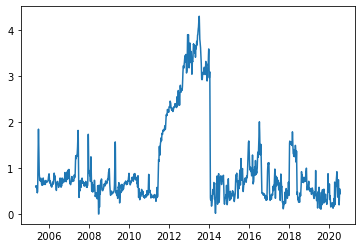

In [32]:
plt.plot(df_final_predictions[0])

# Examples of local increases due to leaks and due to other causes

In [ ]:
# Find good sigma for the size of increase we're interested in


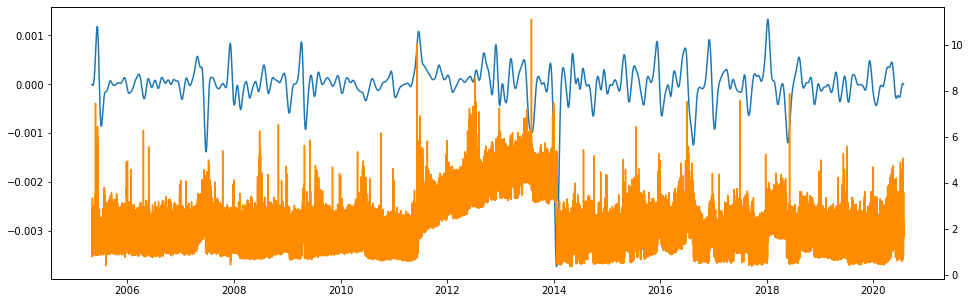

In [46]:
sigma = 300
df_2nd_gaussian = pd.DataFrame(gaussian_filter(df_final_predictions.fillna(method='ffill').loc[:,0],sigma,order=1),index=x.index)

plt.figure(figsize=(16,5))
plt.plot(df_2nd_gaussian.loc[:,0])
plt.gca().twinx().plot(x,color='darkorange')


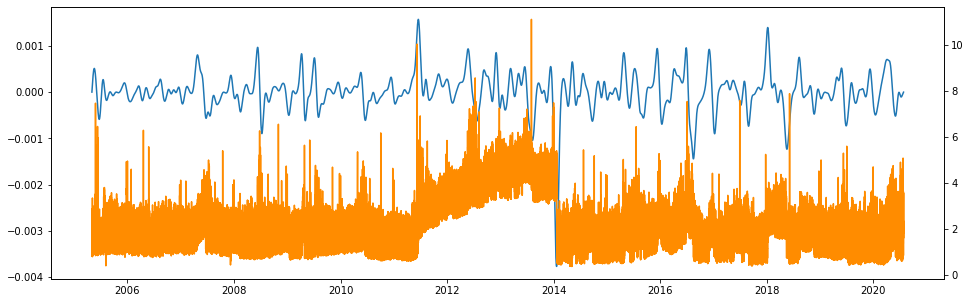

In [45]:
sigma = 300
df_2nd_gaussian = pd.DataFrame(gaussian_filter(x.fillna(method='ffill'),sigma,order=1),index=x.index)

plt.figure(figsize=(16,5))
plt.plot(df_2nd_gaussian.loc[:,0])
plt.gca().twinx().plot(x,color='darkorange')


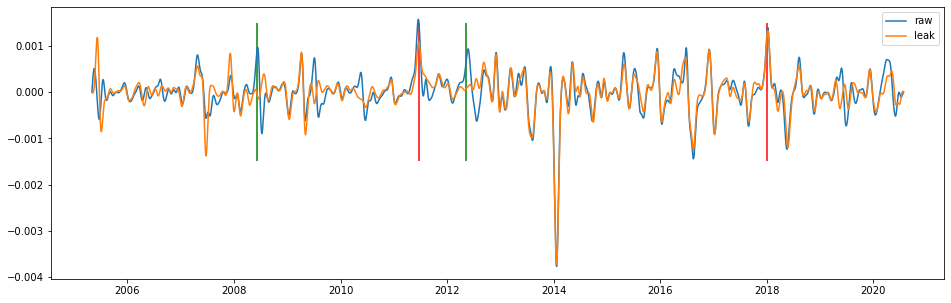

In [153]:
sigma = 300
df_2nd_gaussian = pd.DataFrame(gaussian_filter(x.fillna(method='ffill'),sigma,order=1),index=x.index)

plt.figure(figsize=(16,5))
plt.plot(df_2nd_gaussian.loc[:,0])

sigma = 300
df_2nd_gaussian = pd.DataFrame(gaussian_filter(df_final_predictions.fillna(method='ffill').loc[:,0],sigma,order=1),index=x.index)

plt.plot(df_2nd_gaussian.loc[:,0])
plt.legend(['raw','leak'],loc='upper right')


date_of_interest_1 = dt.date(2008,6,5)
date_of_interest_2 = dt.date(2012,5,10)
dates_of_interest_ok = [date_of_interest_1,date_of_interest_2]
date_of_interest_3 = dt.date(2011,6,25)
date_of_interest_4 = dt.date(2018,1,1)
dates_of_interest_bad = [date_of_interest_3,date_of_interest_4]
plt.vlines(dates_of_interest_ok,-1.5e-3,1.5e-3,color='green')
plt.vlines(dates_of_interest_bad,-1.5e-3,1.5e-3,color='red')

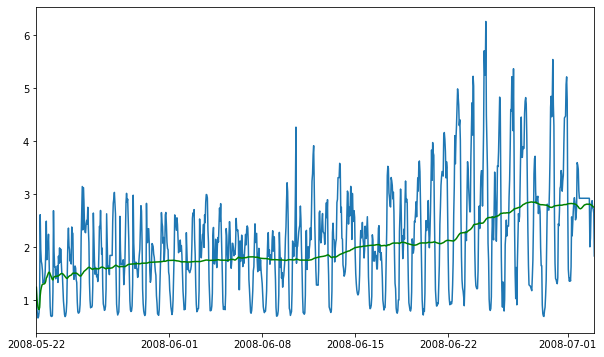

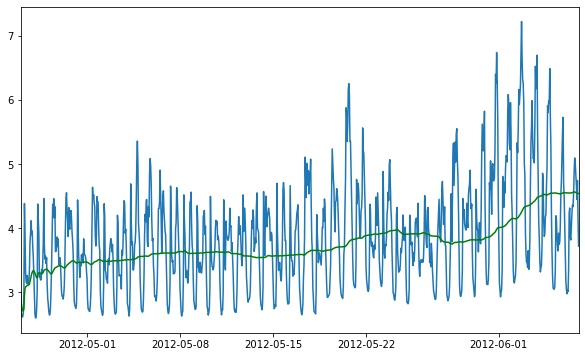

In [149]:
for doi in dates_of_interest_ok:
    plt.figure(figsize=(10,6))
    start,end = doi-dt.timedelta(weeks=2),doi+dt.timedelta(weeks=4)
    ###
#     subset = df_single_nmf_prediction.loc[start:end]
#     plt.plot(subset.sum(axis=1))
    
#     subset = df_final_predictions.loc[start:end]
#     plt.plot(subset.sum(axis=1))
    
    subset = x.loc[start:end]
    plt.plot(subset.index,subset)
    plt.plot(subset.rolling(168,min_periods=0).mean(),c='green')
    
    ### Estimate
    ### Real data
#     subset = df_test.loc[start:end]
#     plt.plot(subset.Val)
    ###
    
    plt.xlim(start,end)
#     plt.vlines(doi,min(subset),max(subset))
    plt.show()
    

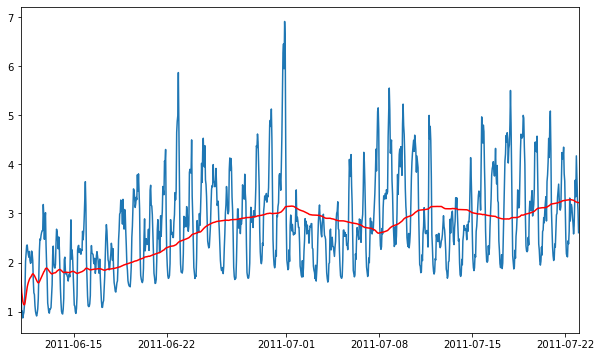

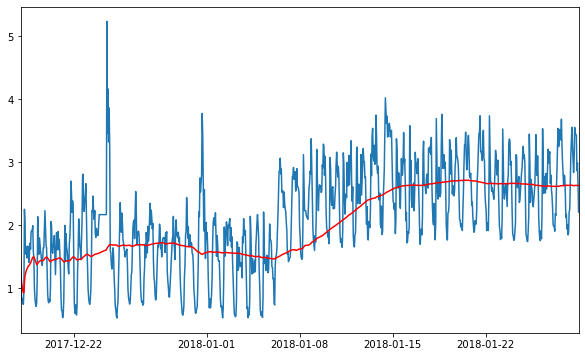

In [154]:
for doi in dates_of_interest_bad:
    plt.figure(figsize=(10,6))
    start,end = doi-dt.timedelta(weeks=2.1),doi+dt.timedelta(weeks=4)
    
    subset = x.loc[start:end]
    plt.plot(subset.index,subset)
    plt.plot(subset.rolling(168,min_periods=0).mean(),c='red')
    
    plt.xlim(start,end)
#     plt.vlines(doi,min(subset),max(subset))
    plt.show()
    
    
    

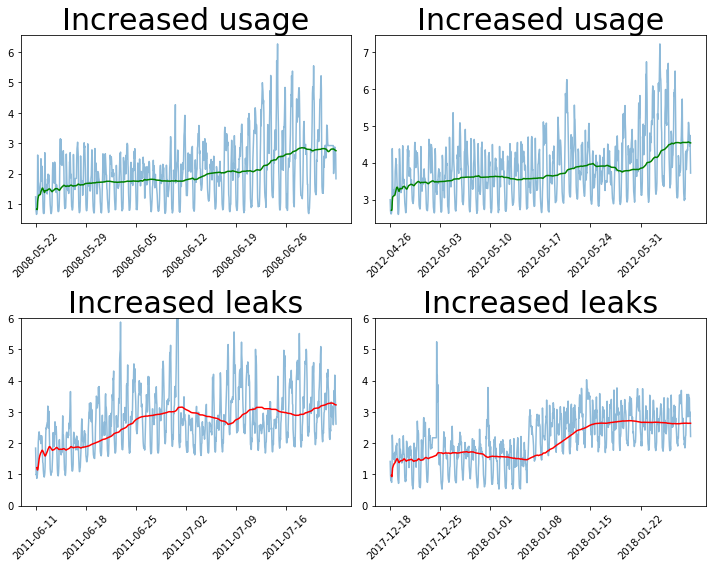

In [190]:
f,ax = plt.subplots(2,2,figsize=(10,8),sharex=False)


for date,upper in zip(dates_of_interest_ok,ax[0]):
    start,end = date-dt.timedelta(weeks=2.1),date+dt.timedelta(weeks=4)
    subset = x.loc[start:end]
    upper.plot(subset.index,subset,alpha=0.5)
    upper.plot(subset.rolling(168,min_periods=5).mean(),c='green')
    
    upper.set_xticks(np.arange(start,end,dt.timedelta(weeks=1)))
    upper.xaxis.set_tick_params(rotation=45)
    
    upper.set_title('Increased usage',fontsize=30)
    
for date,lower in zip(dates_of_interest_bad,ax[1]):
    
    start,end = date-dt.timedelta(weeks=2.1),date+dt.timedelta(weeks=4)
    subset = x.loc[start:end]
    lower.plot(subset.index,subset,alpha=0.5)
    lower.plot(subset.rolling(168,min_periods=5).mean(),c='red')

    lower.set_xticks(np.arange(start,end,dt.timedelta(weeks=1)))
    lower.xaxis.set_tick_params(rotation=45)
    lower.set_ylim(0,6)
    lower.set_title('Increased leaks',fontsize=30)
    
plt.tight_layout()